In [1]:
import re
import os
import time
import random
import requests
import numpy as np
import pandas as pd
from os import system
from math import floor
from copy import deepcopy
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from imblearn.over_sampling import SMOTE

import time
from selenium.webdriver.chrome.options import Options



Using TensorFlow backend.


# SQL

In [4]:
import sqlite3
import mysql.connector
import config
from mysql.connector import errorcode
from datetime import date, datetime, timedelta

In [5]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.password,
)
cursor = cnx.cursor(buffered=True)

In [6]:
db_name = 'hotels'

In [7]:
def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)

try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

Database hotels does not exists.
Database hotels created successfully.


In [8]:
create_hotels = """
CREATE TABLE hotels (
hotel_title TEXT,
hotel_price TEXT,
hotel_star TEXT,
hotel_room TEXT,
hotel_restaurant TEXT,
hotel_bar TEXT,
hotel_fitness TEXT,
hotel_spa TEXT,
hotel_pool TEXT,
valet_parking TEXT,
hotel_limo TEXT,
hotel_rooftop TEXT
);
"""

In [9]:
cursor.execute(create_hotels)
cnx.commit()

In [10]:
def create_hotel_tuple(lst):
    tuple_list = []
    for i in lst:
        new_tuple = (i['hotel_title'],i['hotel_price'], i['hotel_star'], i['hotel_room'], i['hotel_restaurant'],i['hotel_bar'],i['hotel_fitness'],i['hotel_spa'],i['hotel_pool'],i['valet_parking'],i['hotel_limo'],i['hotel_rooftop'])
        tuple_list.append(new_tuple)
    return tuple_list

In [11]:
hotel_tuples = create_hotel_tuple(hotel_list)

In [12]:
def insert_into_hotels(tuple_list):
    insert_hotels = """INSERT INTO hotels(hotel_title, hotel_price, hotel_star, hotel_room, hotel_restaurant, hotel_bar, hotel_fitness, hotel_spa, hotel_pool, valet_parking, hotel_limo, hotel_rooftop)
    VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"""
    cursor.executemany(insert_hotels,tuple_list)
    cnx.commit()

In [13]:
insert_into_hotels(hotel_tuples)

In [20]:
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    password = config.password,
    database = 'hotels'
)
cursor = cnx.cursor(buffered=True)

In [21]:
q = """SELECT * FROM hotels;"""
cursor.execute(q)
df = pd.DataFrame(cursor.fetchall())
df.columns = [x[0] for x in cursor.description]

### Data Cleaning, EDA and Data Engineer

In [23]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [24]:
df.drop([241],axis=0,inplace=True)

In [25]:
df.hotel_price.unique()

array(['229', '345', '107', '140', '119', '134', '199', '159', '173',
       '129', '104', '115', '135', '160', '111', '184', '$75', '179',
       '165', '132', '143', '149', '139', '169', '109', '152', '154',
       '206', '144', '$79', '175', '200', '153', '202', '212', '189',
       '131', '164', '239', '222', '120', '170', '145', '118', '269',
       '155', '204', '185', '223', '$99', '259', '219', '209', '150',
       '188', '180', '249', '198', '122', '237', '255', '114', '295',
       '183', '112', '245', '191', '225', '194', '176', '168', '315',
       '329', '228', '215', '195', '247', '210', '319', '105', '203',
       '288', '300', '172', '350', '275', '$87', '227', '158', '299',
       '240', '161', '260', '230', '309', '305', '279', '335', '151',
       '365', '324', '310', '289', '271', '$84', '314', '214', '359',
       '121', '325', '440', '341', '290', '326', '197', '273', '284',
       '232', '138', '241', '425', '380', '277', '445', '117', '338',
       '374', '459',

In [26]:
#remove '$'
df.hotel_price = df.hotel_price.apply(lambda x: int(x.replace('$','')))

In [27]:
#remove text
df.hotel_star = df.hotel_star.apply(lambda x: float(x.replace('-star','')))

In [28]:
len(df)

900

In [29]:
#remove punctuation
df.hotel_room = df.hotel_room.apply(lambda x: int(x.replace(',','')))

In [30]:
df.sample(5)

,hotel_title,hotel_price,hotel_star,hotel_room,hotel_restaurant,hotel_bar,hotel_fitness,hotel_spa,hotel_pool,valet_parking,hotel_limo,hotel_rooftop
337,SpringHill Suites by Marriott New York Manhatt...,139,3.5,256,Yes,Yes,Yes,No,No,Yes,No,No
253,"St Marks Hotel, New York",119,3.0,64,Yes,Yes,No,No,No,No,No,No
891,"Best Western Far Rockaway Inn, Far Rockaway",110,2.5,58,No,No,Yes,No,No,No,No,No
826,"The Wilshire Grand Hotel, West Orange",140,3.5,89,Yes,Yes,Yes,No,No,No,No,Yes
50,"Artezen Hotel, New York",169,4.0,89,No,No,Yes,No,No,No,Yes,Yes


# EDA


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

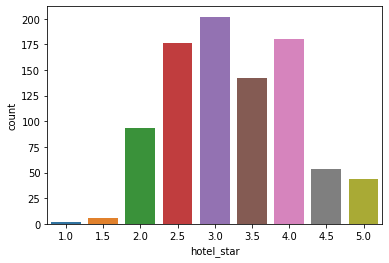

In [32]:
sns.countplot(df.hotel_star)

In [33]:
df['hotel_tier'] = df.hotel_star.apply(lambda x: 'Economy' if x <= 2.5 else('Midscale' if 2.5 < x <= 3.5 else ('Luxury')))


In [34]:
categorical_cols = df.drop(['hotel_title', 'hotel_star','hotel_price','hotel_room','hotel_tier'],axis=1)


In [35]:
for i in list(categorical_cols.columns):
    df[i] = df[i].apply(lambda x: 1 if x == "Yes" else 0)

In [36]:
df.head()

,hotel_title,hotel_price,hotel_star,hotel_room,hotel_restaurant,hotel_bar,hotel_fitness,hotel_spa,hotel_pool,valet_parking,hotel_limo,hotel_rooftop,hotel_tier
0,"Crowne Plaza Times Square Manhattan, New York",229,4.0,795,1,1,1,0,1,1,0,0,Luxury
1,"PUBLIC, an Ian Schrager hotel, New York",345,4.0,367,1,1,1,0,0,0,0,1,Luxury
2,"Meadowlands River Inn, Secaucus",107,2.5,149,0,0,1,0,0,0,0,0,Economy
3,"Hilton Garden Inn Times Square, New York",140,3.5,369,0,0,1,0,0,0,0,0,Midscale
4,"Hampton Inn Times Square North, New York",119,3.0,300,0,0,1,0,0,1,0,0,Midscale


In [465]:
df.corr()

,hotel_price,hotel_star,hotel_room,hotel_restaurant,hotel_bar,hotel_fitness,hotel_spa,hotel_pool,valet_parking,hotel_limo,hotel_rooftop
hotel_price,1.000000,0.627168,0.141020,0.328353,0.345874,0.240655,0.173356,0.067173,0.437677,0.184496,0.178625
hotel_star,0.627168,1.000000,0.368916,0.601961,0.617515,0.380426,0.101563,0.067377,0.569221,0.217304,0.312591
hotel_room,0.141020,0.368916,1.000000,0.360251,0.358893,0.331332,0.097669,0.037989,0.356833,0.086097,0.070716
hotel_restaurant,0.328353,0.601961,0.360251,1.000000,0.799384,0.365210,0.092809,0.154306,0.358771,0.119925,0.226543
hotel_bar,0.345874,0.617515,0.358893,0.799384,1.000000,0.396885,0.090530,0.167645,0.371424,0.129732,0.275154
hotel_fitness,0.240655,0.380426,0.331332,0.365210,0.396885,1.000000,0.054240,0.298191,0.320040,0.108378,0.122110
hotel_spa,0.173356,0.101563,0.097669,0.092809,0.090530,0.054240,1.000000,0.015672,0.073927,0.050570,-0.009215
hotel_pool,0.067173,0.067377,0.037989,0.154306,0.167645,0.298191,0.015672,1.000000,-0.104307,-0.002042,0.101990
valet_parking,0.437677,0.569221,0.356833,0.358771,0.371424,0.320040,0.073927,-0.104307,1.000000,0.213734,0.181466
hotel_limo,0.184496,0.217304,0.086097,0.119925,0.129732,0.108378,0.050570,-0.002042,0.213734,1.000000,0.070574


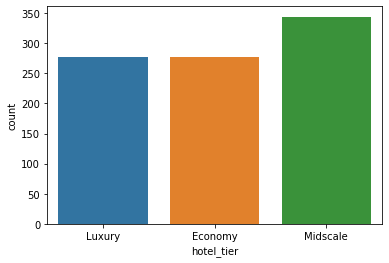

In [37]:
sns.countplot(df.hotel_tier)

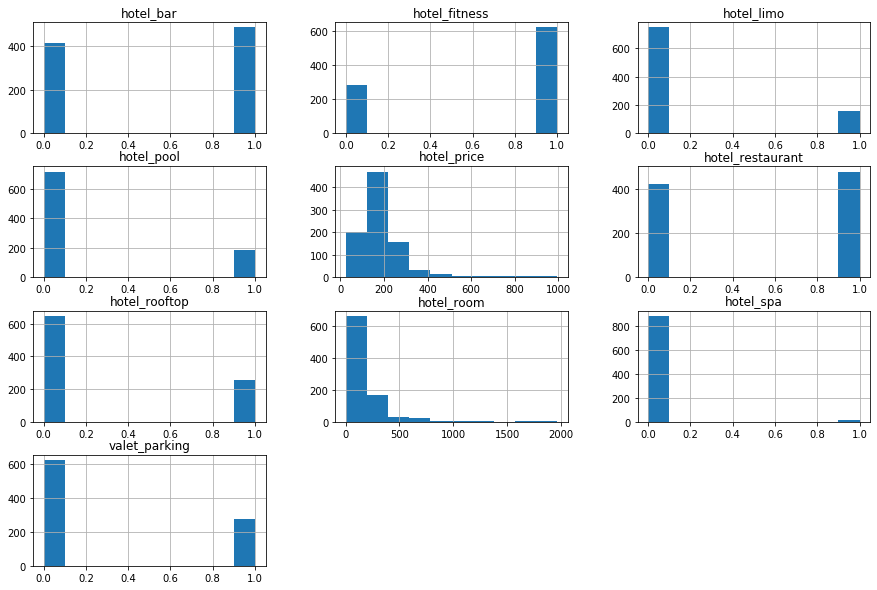

In [38]:
df.drop(['hotel_star'],axis=1).hist(figsize=(15,10));

# Classification


In [41]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,confusion_matrix, classification_report
from sklearn.preprocessing import normalize, scale, StandardScaler, Normalizer
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# Classification Algorithms
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier

In [42]:
#features without price
features = ['hotel_room','hotel_restaurant','hotel_bar','hotel_fitness','hotel_spa','hotel_pool','valet_parking','hotel_limo','hotel_rooftop']

In [43]:
X = df[features]
y = df.hotel_tier

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.fit_transform(X_test)

In [45]:
#features with price
features_w_price = ['hotel_price','hotel_room','hotel_restaurant','hotel_bar','hotel_fitness','hotel_spa','hotel_pool','valet_parking','hotel_limo','hotel_rooftop']

In [46]:
X_p = df[features_w_price]
y_p = df.hotel_tier

In [47]:
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_p, y_p, test_size=0.25)
X_p_train_scaled = scale.fit_transform(X_p_train)
X_p_test_scaled = scale.fit_transform(X_p_test)

In [48]:
def cross_val(models,X_train,y_train):
    for model in models:
        model.fit(X_train,y_train)
        
        print(str(model).split('(')[0],'Cross Validation:')
        print(f"-- Accuracy: {cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean():.2%}")

In [49]:
clf = [RandomForestClassifier(),AdaBoostClassifier(),
      DecisionTreeClassifier(),KNeighborsClassifier(),BernoulliNB(),SVC(),OneVsRestClassifier(SVC())]


In [50]:
#base models on data with price feature
cross_val(clf,X_p_train_scaled,y_p_train);

RandomForestClassifier Cross Validation:
-- Accuracy: 70.52%
AdaBoostClassifier Cross Validation:
-- Accuracy: 70.52%
DecisionTreeClassifier Cross Validation:
-- Accuracy: 64.44%
KNeighborsClassifier Cross Validation:
-- Accuracy: 65.93%
BernoulliNB Cross Validation:
-- Accuracy: 67.11%
SVC Cross Validation:
-- Accuracy: 71.11%
OneVsRestClassifier Cross Validation:
-- Accuracy: 70.37%


In [51]:
#baseline models
cross_val(clf,X_train_scaled,y_train);

RandomForestClassifier Cross Validation:
-- Accuracy: 60.89%
AdaBoostClassifier Cross Validation:
-- Accuracy: 64.59%
DecisionTreeClassifier Cross Validation:
-- Accuracy: 58.96%
KNeighborsClassifier Cross Validation:
-- Accuracy: 64.00%
BernoulliNB Cross Validation:
-- Accuracy: 63.70%
SVC Cross Validation:
-- Accuracy: 68.59%
OneVsRestClassifier Cross Validation:
-- Accuracy: 68.59%


#### Base on Accuracy of the models after cross validation, Ada Boost Classifer, Bernoulli Naive Bayes and Support Vector Classification are selected. Even though low on Accuracy score, I also want to test Random Forest with different parameters.

In [ ]:
clf_CV = [RandomForestClassifier(),AdaBoostClassifier(), BernoulliNB(), SVC()]

# Tunning Models

### Random Forest

In [52]:
def gs_rf(X_train,y_train):

    param =  [{'criterion': ['gini', 'entropy'],'max_depth': [5,10,15], 
                     'n_estimators' : [10,50,100] }]
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid = param, verbose = 3, cv = 3,n_jobs= -1, scoring = 'accuracy')
    grid_search.fit(X_train, y_train)
    output =  [grid_search.best_score_,grid_search.best_params_]
    
        
    return output

In [53]:
#without price
gs_rf(X_train_scaled,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    4.8s finished


[0.6903703703703704,
 {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}]

In [54]:
#with price
gs_rf(X_p_train_scaled,y_p_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    2.6s finished


[0.7303703703703704,
 {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}]

### AdaBoosting Classifier

In [55]:
def gs_abc(X_train,y_train):
    param = [{'learning_rate': [0.1,0.3,0.5,0.8,1],'n_estimators': [50,100,200,300]}]
    grid_search = GridSearchCV(AdaBoostClassifier(), param_grid = param, verbose = 1, cv = 3,n_jobs= -1, scoring = 'accuracy')
    grid_search.fit(X_train, y_train)
    param = [f'{grid_search.best_score_:.2%}', grid_search.best_params_ ]
    return  param

In [56]:
#without price
gs_abc(X_train_scaled,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.2s finished


['65.04%', {'learning_rate': 0.1, 'n_estimators': 100}]

In [57]:
#with price
gs_abc(X_p_train_scaled, y_p_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   11.1s finished


['71.70%', {'learning_rate': 0.3, 'n_estimators': 50}]

### Bernoulli Naive Bayes

In [58]:
def gs_bnb(X_train,y_train):
    param = [{'alpha': [0.1,0.2,0.3,0.5,0.8,1]}]
    grid_search = GridSearchCV(BernoulliNB(), param_grid = param, verbose = 1, cv = 3,n_jobs= -1, scoring = 'accuracy')
    grid_search.fit(X_train, y_train)
    param = [f'{grid_search.best_score_:.2%}', grid_search.best_params_ ]
    return  param

In [59]:
#without price
gs_bnb(X_train_scaled, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished


['64.74%', {'alpha': 0.8}]

In [60]:
#with price
gs_bnb(X_p_train_scaled, y_p_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished


['67.56%', {'alpha': 0.2}]

### Suport Vector Classification

In [61]:
def gs_SVC(X_train,y_train):
    param = [{'kernel':('linear', 'rbf','poly'), 'C':[1,5,10]}]
    grid_search = GridSearchCV(SVC(), param_grid = param, verbose = 1, cv = 3,n_jobs= -1, scoring = 'accuracy')
    grid_search.fit(X_train, y_train)
    param = [f'{grid_search.best_score_:.2%}', grid_search.best_params_ ]
    return  param

In [62]:
gs_SVC(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.3s finished


['67.85%', {'C': 1, 'kernel': 'rbf'}]

In [63]:
gs_SVC(X_p_train_scaled, y_p_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.3s finished


['71.11%', {'C': 5, 'kernel': 'linear'}]

# Apply models to test data

In [64]:
def plot_feature_importances(model,X_train_scaled):
    n_features = X_train_scaled.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")


In [65]:
def fit_model_tree(model,features, X_train, y_train, X_test, y_test):
    
    model = model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    prob = model.predict_proba(X_test)
    
    print(str(model).split('(')[0],':')
    print('Train: \n Accuracy:', round(accuracy_score(y_train, train_pred),3),
          '\n Recall',recall_score(y_train, train_pred,average=None),
          '\n Precision',precision_score(y_train, train_pred,average=None),
          '\n f1',f1_score(y_train, train_pred,average=None))
    
    print('Test: \n Accuracy:', round(accuracy_score(y_test, test_pred),3),
          '\n Recall',recall_score(y_test, test_pred,average=None),
          '\n Precision',precision_score(y_test, test_pred,average=None),
          '\n f1',f1_score(y_test, test_pred,average=None))
    
    feature_importances = model.feature_importances_
    feature_indices = np.argsort(feature_importances)[::-1]
    print(' ')
    print('Features Importance Order')
    for f,index in enumerate(feature_indices):
        print("%2d) %-*s %f" % (f + 1, 30,features[index], feature_importances[index]))
    plot_feature_importances(model,X_train)
    return train_pred, test_pred

## Random Forest

#### Without price

In [66]:
rf = RandomForestClassifier(criterion= 'gini', max_depth= 5, n_estimators= 50)

RandomForestClassifier :
Train: 
 Accuracy: 0.75 
 Recall [0.8872549  0.72727273 0.66030534] 
 Precision [0.75732218 0.79166667 0.70901639] 
 f1 [0.81715576 0.75810474 0.68379447]
Test: 
 Accuracy: 0.702 
 Recall [0.78378378 0.72463768 0.6097561 ] 
 Precision [0.76315789 0.74626866 0.6097561 ] 
 f1 [0.77333333 0.73529412 0.6097561 ]
 
Features Importance Order
 1) hotel_bar                      0.276176
 2) hotel_room                     0.210923
 3) hotel_restaurant               0.191412
 4) valet_parking                  0.182609
 5) hotel_rooftop                  0.044581
 6) hotel_pool                     0.031542
 7) hotel_limo                     0.029911
 8) hotel_fitness                  0.028106
 9) hotel_spa                      0.004741


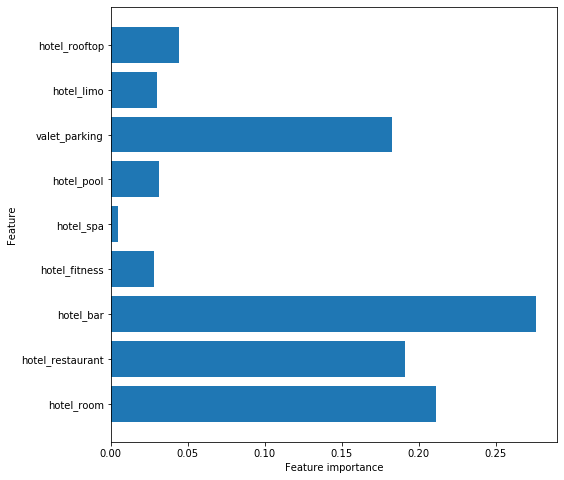

In [67]:
rf_train_pred, rf_test_pred = fit_model_tree(rf,features,X_train_scaled, y_train, X_test_scaled, y_test)

#### With price

In [68]:
rf_p = RandomForestClassifier(criterion= 'gini', max_depth= 5, n_estimators= 100)

RandomForestClassifier :
Train: 
 Accuracy: 0.797 
 Recall [0.875      0.77511962 0.7556391 ] 
 Precision [0.82159624 0.83505155 0.75      ] 
 f1 [0.84745763 0.80397022 0.75280899]
Test: 
 Accuracy: 0.782 
 Recall [0.82051282 0.72463768 0.79487179] 
 Precision [0.86486486 0.89285714 0.65263158] 
 f1 [0.84210526 0.8        0.71676301]
 
Features Importance Order
 1) hotel_price                    0.314465
 2) hotel_bar                      0.183971
 3) hotel_restaurant               0.148344
 4) hotel_room                     0.144519
 5) valet_parking                  0.109358
 6) hotel_rooftop                  0.038635
 7) hotel_pool                     0.025379
 8) hotel_fitness                  0.018755
 9) hotel_limo                     0.015140
10) hotel_spa                      0.001435


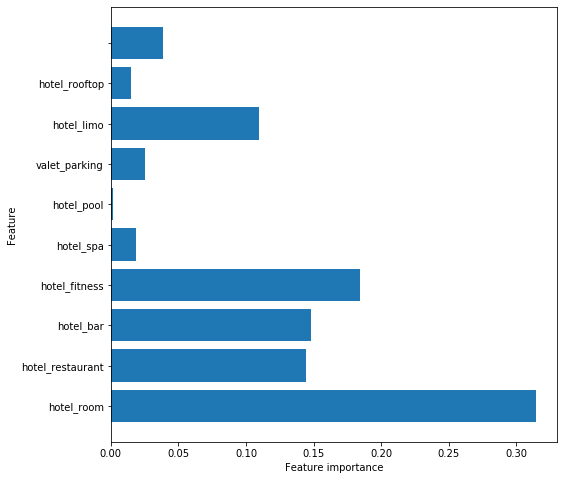

In [69]:
#with price
rf_p_train_pred, rf_p_test_pred = fit_model_tree(rf_p,features_w_price, X_p_train_scaled, y_p_train, X_p_test_scaled, y_p_test)


## AdaBoost

#### Without price

In [70]:
abc = AdaBoostClassifier(learning_rate= 0.5, n_estimators= 100)

AdaBoostClassifier :
Train: 
 Accuracy: 0.687 
 Recall [0.81372549 0.71291866 0.56870229] 
 Precision [0.74107143 0.70616114 0.62083333] 
 f1 [0.77570093 0.70952381 0.5936255 ]
Test: 
 Accuracy: 0.711 
 Recall [0.81081081 0.75362319 0.58536585] 
 Precision [0.77922078 0.72222222 0.63157895] 
 f1 [0.79470199 0.73758865 0.60759494]
 
Features Importance Order
 1) hotel_room                     0.610000
 2) hotel_restaurant               0.080000
 3) hotel_fitness                  0.070000
 4) hotel_rooftop                  0.060000
 5) valet_parking                  0.060000
 6) hotel_pool                     0.050000
 7) hotel_bar                      0.040000
 8) hotel_limo                     0.030000
 9) hotel_spa                      0.000000


(array(['Midscale', 'Luxury', 'Economy', 'Economy', 'Economy', 'Midscale',
        'Midscale', 'Economy', 'Midscale', 'Midscale', 'Midscale',
        'Midscale', 'Economy', 'Luxury', 'Midscale', 'Economy', 'Midscale',
        'Luxury', 'Midscale', 'Economy', 'Luxury', 'Economy', 'Luxury',
        'Luxury', 'Midscale', 'Midscale', 'Midscale', 'Economy',
        'Midscale', 'Luxury', 'Midscale', 'Economy', 'Midscale', 'Economy',
        'Midscale', 'Economy', 'Economy', 'Midscale', 'Luxury', 'Luxury',
        'Economy', 'Economy', 'Luxury', 'Luxury', 'Luxury', 'Luxury',
        'Luxury', 'Economy', 'Luxury', 'Midscale', 'Economy', 'Midscale',
        'Luxury', 'Luxury', 'Midscale', 'Economy', 'Midscale', 'Luxury',
        'Economy', 'Midscale', 'Midscale', 'Luxury', 'Luxury', 'Economy',
        'Luxury', 'Economy', 'Midscale', 'Luxury', 'Luxury', 'Luxury',
        'Midscale', 'Economy', 'Midscale', 'Luxury', 'Luxury', 'Economy',
        'Midscale', 'Midscale', 'Midscale', 'Luxury', 'Mids

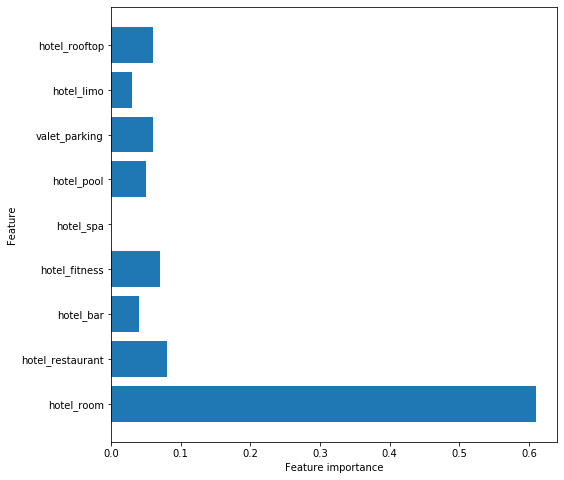

In [71]:
fit_model_tree(abc,features,X_train_scaled, y_train, X_test_scaled, y_test)

#### With price

In [72]:
abc_p = AdaBoostClassifier(learning_rate= 0.3, n_estimators= 50)

AdaBoostClassifier :
Train: 
 Accuracy: 0.741 
 Recall [0.85       0.6507177  0.72932331] 
 Precision [0.81339713 0.79069767 0.65986395] 
 f1 [0.83129584 0.71391076 0.69285714]
Test: 
 Accuracy: 0.773 
 Recall [0.80769231 0.71014493 0.79487179] 
 Precision [0.88732394 0.85964912 0.63917526] 
 f1 [0.84563758 0.77777778 0.70857143]
 
Features Importance Order
 1) hotel_price                    0.380000
 2) hotel_room                     0.220000
 3) hotel_restaurant               0.140000
 4) valet_parking                  0.080000
 5) hotel_rooftop                  0.060000
 6) hotel_bar                      0.060000
 7) hotel_fitness                  0.040000
 8) hotel_limo                     0.020000
 9) hotel_pool                     0.000000
10) hotel_spa                      0.000000


(array(['Economy', 'Economy', 'Economy', 'Economy', 'Midscale', 'Midscale',
        'Midscale', 'Luxury', 'Economy', 'Luxury', 'Economy', 'Economy',
        'Midscale', 'Midscale', 'Midscale', 'Midscale', 'Midscale',
        'Midscale', 'Economy', 'Midscale', 'Economy', 'Luxury', 'Economy',
        'Midscale', 'Midscale', 'Luxury', 'Midscale', 'Midscale', 'Luxury',
        'Midscale', 'Economy', 'Midscale', 'Midscale', 'Midscale',
        'Luxury', 'Midscale', 'Luxury', 'Midscale', 'Midscale', 'Luxury',
        'Economy', 'Midscale', 'Luxury', 'Midscale', 'Economy', 'Economy',
        'Midscale', 'Luxury', 'Midscale', 'Midscale', 'Economy', 'Economy',
        'Economy', 'Luxury', 'Luxury', 'Luxury', 'Economy', 'Economy',
        'Luxury', 'Midscale', 'Luxury', 'Midscale', 'Economy', 'Midscale',
        'Economy', 'Midscale', 'Midscale', 'Midscale', 'Economy',
        'Midscale', 'Midscale', 'Economy', 'Luxury', 'Luxury', 'Midscale',
        'Midscale', 'Luxury', 'Midscale', 'Economy', 

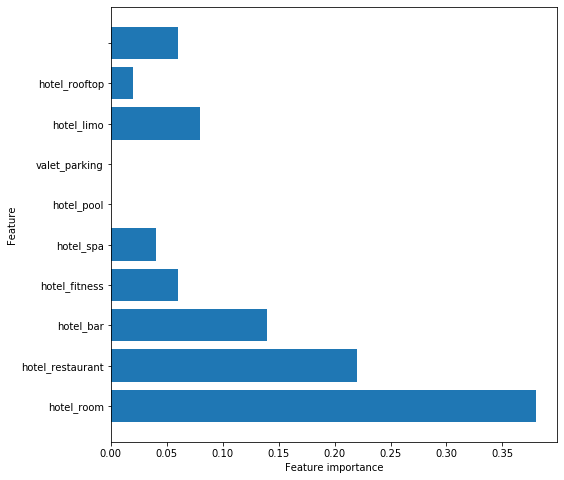

In [73]:
fit_model_tree(abc_p,features_w_price,X_p_train_scaled, y_p_train, X_p_test_scaled, y_p_test)

## Bernoulli Naive Bayes

In [74]:
def fit_model(model, X_train, y_train, X_test, y_test):
    
    model = model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    
    print(str(model).split('(')[0],':')
    print('Train: \n Accuracy:', round(accuracy_score(y_train, train_pred),3),
          '\n Recall',recall_score(y_train, train_pred,average=None),
          '\n Precision',precision_score(y_train, train_pred,average=None),
          '\n f1',f1_score(y_train, train_pred,average=None))
    
    print('Test: \n Accuracy:', round(accuracy_score(y_test, test_pred),3),
          '\n Recall',recall_score(y_test, test_pred,average=None),
          '\n Precision',precision_score(y_test, test_pred,average=None),
          '\n f1',f1_score(y_test, test_pred,average=None))

#### Without price

In [75]:
bnb = BernoulliNB(alpha= 0.1)

In [76]:
fit_model(bnb,X_train_scaled, y_train, X_test_scaled, y_test)

BernoulliNB :
Train: 
 Accuracy: 0.659 
 Recall [0.83823529 0.73684211 0.45801527] 
 Precision [0.71548117 0.66094421 0.591133  ] 
 f1 [0.77200903 0.69683258 0.51612903]
Test: 
 Accuracy: 0.671 
 Recall [0.81081081 0.75362319 0.47560976] 
 Precision [0.75       0.66666667 0.58208955] 
 f1 [0.77922078 0.70748299 0.52348993]


#### With price

In [77]:
bnb_p = BernoulliNB(alpha= 0.1)

In [78]:
fit_model(bnb_p,X_p_train_scaled, y_p_train, X_p_test_scaled, y_p_test)

BernoulliNB :
Train: 
 Accuracy: 0.681 
 Recall [0.845      0.75119617 0.5037594 ] 
 Precision [0.71610169 0.69469027 0.62910798] 
 f1 [0.77522936 0.72183908 0.55949896]
Test: 
 Accuracy: 0.747 
 Recall [0.82051282 0.75362319 0.66666667] 
 Precision [0.83116883 0.8        0.62650602] 
 f1 [0.82580645 0.7761194  0.64596273]


## SVC


#### Without price

In [79]:
svc = SVC(C= 1, kernel= 'rbf')

In [80]:
fit_model(svc,X_train_scaled, y_train, X_test_scaled, y_test)

SVC :
Train: 
 Accuracy: 0.716 
 Recall [0.86764706 0.68421053 0.6221374 ] 
 Precision [0.73443983 0.78142077 0.64940239] 
 f1 [0.79550562 0.72959184 0.63547758]
Test: 
 Accuracy: 0.698 
 Recall [0.85135135 0.66666667 0.58536585] 
 Precision [0.75       0.75409836 0.6       ] 
 f1 [0.79746835 0.70769231 0.59259259]


#### With price

In [81]:
svc_p = SVC(C= 5, kernel= 'linear')

In [82]:
fit_model(svc_p,X_p_train_scaled, y_p_train, X_p_test_scaled, y_p_test)

SVC :
Train: 
 Accuracy: 0.736 
 Recall [0.865      0.69856459 0.66917293] 
 Precision [0.79357798 0.76041667 0.67169811] 
 f1 [0.8277512  0.72817955 0.67043315]
Test: 
 Accuracy: 0.778 
 Recall [0.84615385 0.76811594 0.71794872] 
 Precision [0.89189189 0.77941176 0.6746988 ] 
 f1 [0.86842105 0.77372263 0.69565217]


## OneVsRest Classifier

### Without price

In [83]:
ovr = OneVsRestClassifier(SVC())

In [84]:
fit_model(svc,X_train_scaled, y_train, X_test_scaled, y_test)

SVC :
Train: 
 Accuracy: 0.716 
 Recall [0.86764706 0.68421053 0.6221374 ] 
 Precision [0.73443983 0.78142077 0.64940239] 
 f1 [0.79550562 0.72959184 0.63547758]
Test: 
 Accuracy: 0.698 
 Recall [0.85135135 0.66666667 0.58536585] 
 Precision [0.75       0.75409836 0.6       ] 
 f1 [0.79746835 0.70769231 0.59259259]


### With price

In [85]:
fit_model(svc,X_p_train_scaled, y_p_train, X_p_test_scaled, y_p_test)

SVC :
Train: 
 Accuracy: 0.745 
 Recall [0.865      0.77033493 0.63533835] 
 Precision [0.74891775 0.78921569 0.70416667] 
 f1 [0.80278422 0.77966102 0.66798419]
Test: 
 Accuracy: 0.738 
 Recall [0.79487179 0.72463768 0.69230769] 
 Precision [0.83783784 0.78125    0.62068966] 
 f1 [0.81578947 0.7518797  0.65454545]


### I have better predictive power using the features with price. However, I think it is common sense to see that the more expensive it is, the higher the tier of the hotel. Without the price feature, size of the hotel, aka the number of rooms a hotel has, and whether a hotel has restaurants are important factors in deciding which tier the hotel belongs to.

## Confusion Matrix

#### Random Forest

In [86]:
rf_confustion = confusion_matrix(y_test, rf_test_pred)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a38fc9c90>)

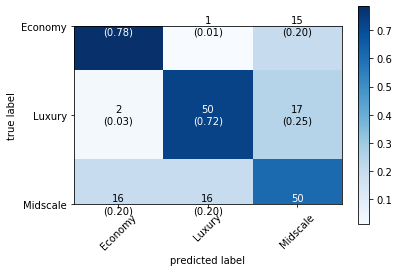

In [87]:

plot_confusion_matrix(rf_confustion,show_absolute=True,
                                show_normed=True,
                                colorbar=True,class_names=['Economy','Luxury','Midscale'])

In [88]:
rf_p_confusion = confusion_matrix(y_p_test, rf_p_test_pred)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a385c8910>)

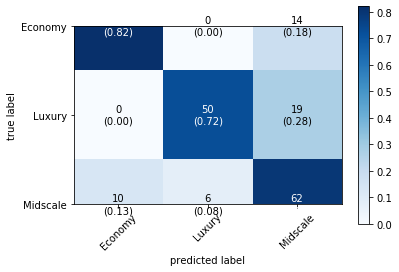

In [89]:
plot_confusion_matrix(rf_p_confusion,show_absolute=True,
                                show_normed=True,
                                colorbar=True,class_names=['Economy','Luxury','Midscale'])